In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [7]:
model_version = "v8.0"

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [4]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32')(inputs)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_32.2')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.load_weights(f'models/{model_version}/spec_photo_model.h5', by_name=True, skip_mismatch=True)

model.get_layer('Dense_32').trainable = False
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False
model.get_layer('Dense_256').trainable = False
model.get_layer('Dense_32.2').trainable = True

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 Dense_32 (Dense)            (None, 32)                1280      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Dense_64 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [13]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/200
4467/4467 [==============================] - 25s 6ms/step - loss: 6.6531 - mae: 1.8925 - mse: 6.1399 - mape: 17.9266 - val_loss: 1.0953 - val_mae: 0.6671 - val_mse: 0.6742 - val_mape: 6.2584
Epoch 2/200
4467/4467 [==============================] - 25s 6ms/step - loss: 3.0630 - mae: 1.2967 - mse: 2.6735 - mape: 12.3193 - val_loss: 0.8289 - val_mae: 0.5344 - val_mse: 0.4539 - val_mape: 5.1233
Epoch 3/200
4467/4467 [==============================] - 25s 6ms/step - loss: 1.6862 - mae: 0.9033 - mse: 1.3118 - mape: 8.6188 - val_loss: 0.8525 - val_mae: 0.5557 - val_mse: 0.4768 - val_mape: 5.2961
Epoch 4/200
4467/4467 [==============================] - 25s 6ms/step - loss: 1.0332 - mae: 0.6333 - mse: 0.6583 - mape: 6.0950 - val_loss: 0.7985 - val_mae: 0.4956 - val_mse: 0.4250 - val_mape: 4.8297
Epoch 5/200
4467/4467 [==============================] - 25s 6ms/step - loss: 0.8312 - mae: 0.5196 - mse: 0.4586 - mape: 5.0459 - val_loss: 0.7991 - val_mae: 0.4923 - val_mse: 0.4269 - val_m

In [14]:
def plot_visualizations(history, y_test, y_pred):
    y_pred_flat = y_pred.ravel()
    y_test_flat = y_test.iloc[:, 0].values.ravel()

    residuals = y_test_flat - y_pred_flat

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss', color='steelblue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['mae'], label='Training MAE', color='darkgreen')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Absolute Error")
    plt.title("Training vs Validation MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

In [17]:
y_pred = model.predict(X_test_scaled)

1396/1396 [==============================] - 2s 1ms/step


In [18]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.4978
Root Mean Squared Error (RMSE): 0.6572
R² Score: 0.0081


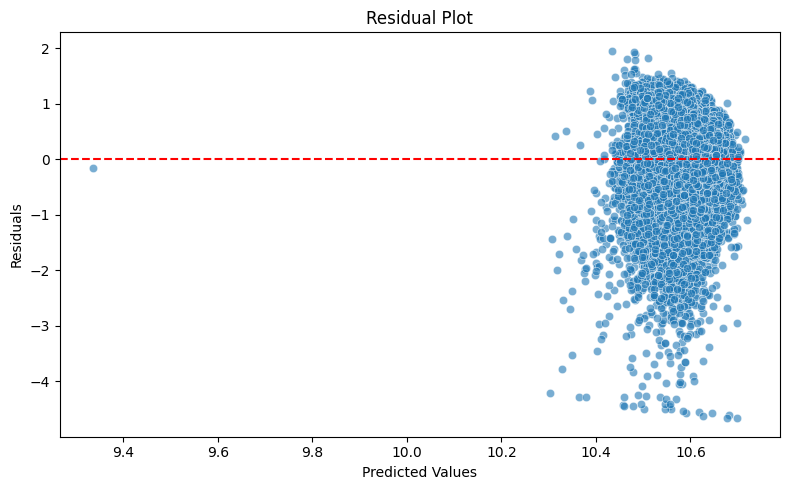

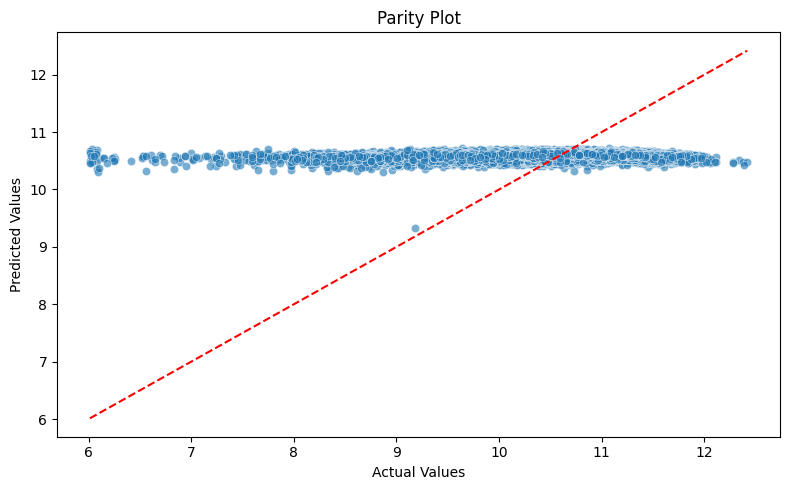

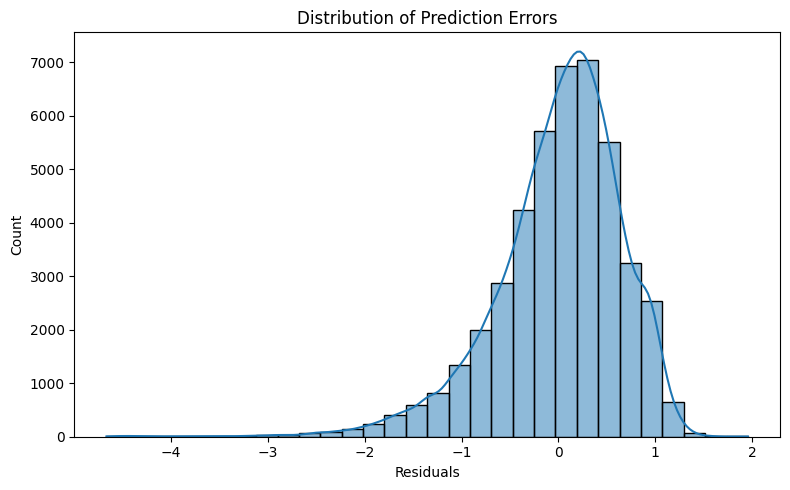

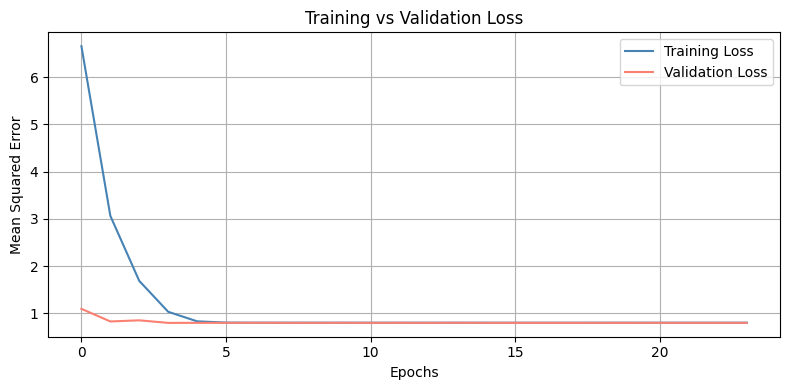

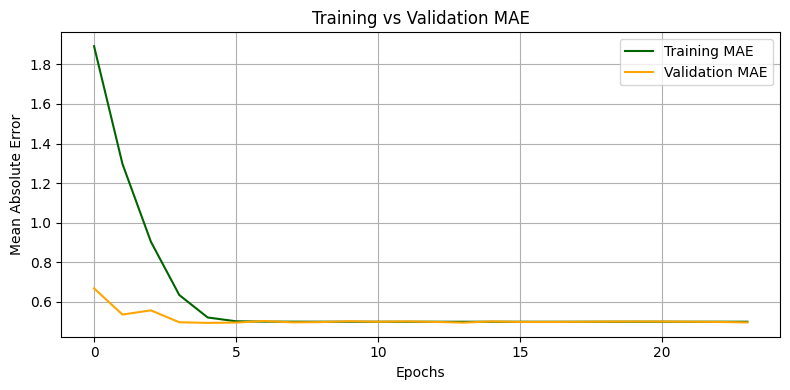

In [19]:
plot_visualizations(history, y_test, y_pred)